This short code analyzes a dataset of already normalized data related to certain parameters and the possible presence of a tumor. First, the correlation matrix and PCA are displayed. Then, two algorithms are used to predict the likelihood of a tumor: Neural Network (NN) and Random Forest (RF), both with a 70/30 train/test split. Finally, the confusion matrix and ROC AUC are shown for both models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


In [ ]:
# Initialization of the data
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/tumor.csv"


df = pd.read_csv(file_path)
df



valori_per_colonna = df.count()

# Print the first five row, the columns name, the eventual missing value and the tipe
print(df.head())

list(df.columns)
missing_per_column = df.isna().sum()
print(missing_per_column)
df.dtypes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0  Clump  UnifSize  UnifShape  MargAdh  SingEpiSize  BareNuc  \
0           0      5         1          1        1            2        1   
1           1      5         4          4        5            7       10   
2           2      3         1          1        1            2        2   
3           3      6         8          8        1            3        4   
4           4      4         1          1        3            2        1   

   BlandChrom  NormNucl  Mit  Class  
0           3         1    1      0  
1           3         2    1      0  
2           3         1    1      0  
3           3         7    1      0  
4           3         1    1      0  
Unnamed: 0     0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0

,0
Unnamed: 0,int64
Clump,int64
UnifSize,int64
UnifShape,int64
MargAdh,int64
SingEpiSize,int64
BareNuc,int64
BlandChrom,int64
NormNucl,int64
Mit,int64


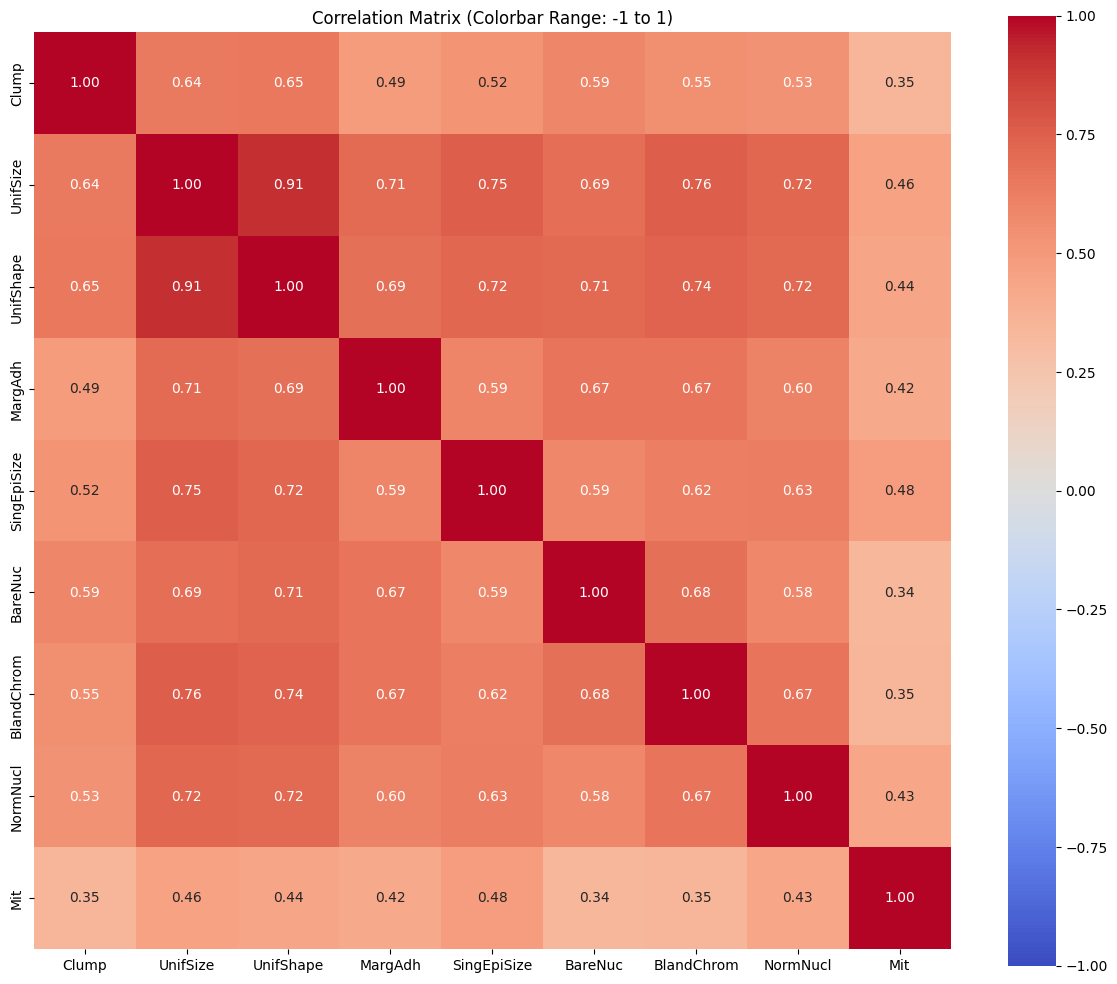

In [ ]:
#CONFUSION MATRIX

# selecting the data without the firs row (numerical) and the last (the thing we want to predict))
df_selected = df.iloc[:, 1:-1]

# Compute the correlation matrix for columns
correlation_matrix = df_selected.corr()
float_columns = [x for x in df_selected.columns]
skew_columns = (df[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
corr_mat = df[float_columns].corr()

# Plot the correlation matrix as a heatmap with fixed colorbar range (-1 to 1)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    vmin=-1,  # Minimum value of the colorbar
    vmax=1    # Maximum value of the colorbar
)
plt.title("Correlation Matrix (Colorbar Range: -1 to 1)")
plt.tight_layout()
plt.show()


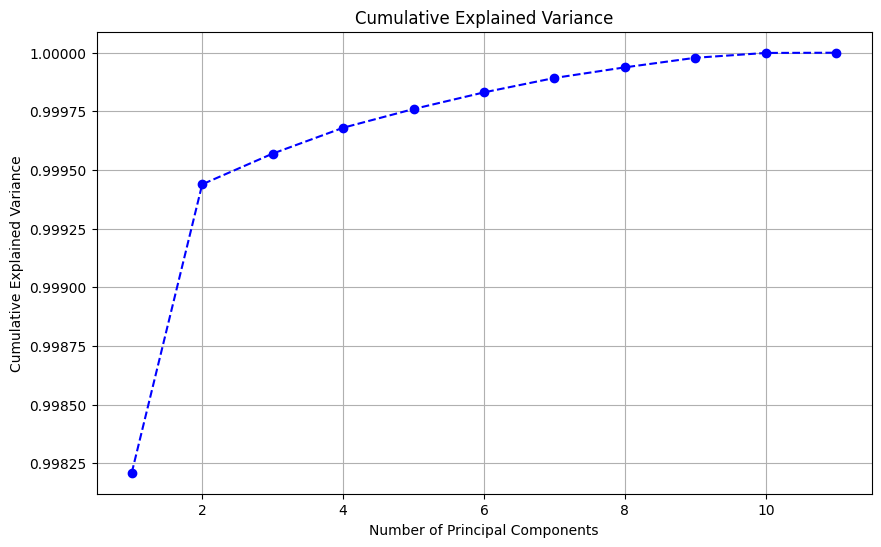

In [ ]:
#Perform PCA on the filtered data
pca = PCA()
pca.fit(df)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
# SSelection of the data
X = df_selected
y = df.iloc[:, 10].values


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Neural Network Classifier
nn = MLPClassifier(hidden_layer_sizes=(1), max_iter=1000, random_state=42)
nn.fit(X_train_scaled, y_train)
nn_pred = nn.predict(X_test_scaled)

# Evaluate models
rf_acc = accuracy_score(y_test, rf_pred)
nn_acc = accuracy_score(y_test, nn_pred)

print(f"Random Forest Accuracy: {rf_acc:.2f}")
print(f"Neural Network Accuracy: {nn_acc:.2f}")
print("\nClassification Report for Random Forest:\n", classification_report(y_test, rf_pred))
print("\nClassification Report for Neural Network:\n", classification_report(y_test, nn_pred))


Random Forest Accuracy: 0.95
Neural Network Accuracy: 0.96

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       127
           1       0.97      0.90      0.93        78

    accuracy                           0.95       205
   macro avg       0.96      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205


Classification Report for Neural Network:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       127
           1       0.95      0.94      0.94        78

    accuracy                           0.96       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.96      0.96      0.96       205



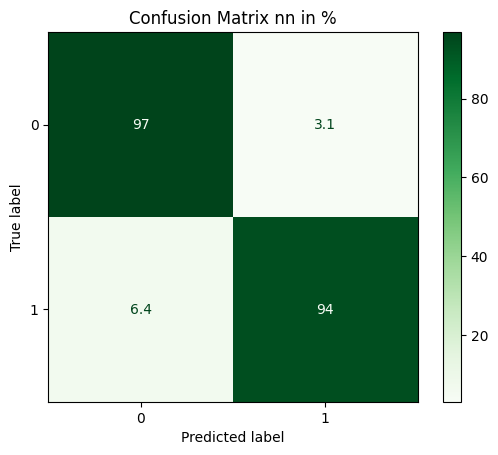

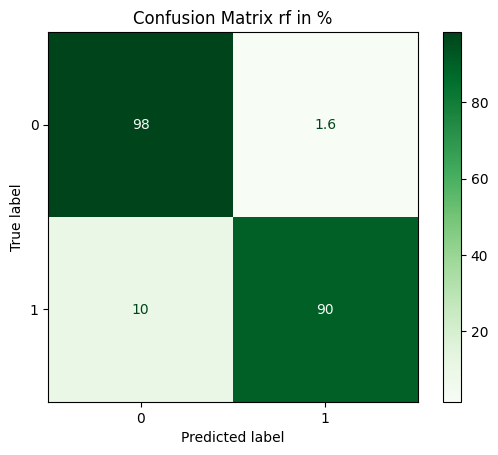

In [ ]:
# Confusion matrix for nn and rf algoritm

cm_nn = confusion_matrix(y_test, nn_pred, labels=nn.classes_)
cm_percent_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent_nn)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix nn in %")
plt.show()

cm_rf = confusion_matrix(y_test, rf_pred, labels=rf.classes_)
cm_percent_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent_rf)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix rf in %")
plt.show()


In [ ]:
# Encode the target variable into binary format for ROC AUC calculation for nn and rf algoritm
y_test_bin_nn = label_binarize(y_test, classes=[0, 1])
y_pred_proba_nn = nn.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test_bin_nn, y_pred_proba_nn, multi_class='ovr')
print(f"ROC AUC Score nn: {roc_auc:.4f}")

y_test_bin_rf = label_binarize(y_test, classes=[0, 1])
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test_bin_rf, y_pred_proba_rf, multi_class='ovr')
print(f"ROC AUC Score rf: {roc_auc:.4f}")


ROC AUC Score nn: 0.9900
ROC AUC Score rf: 0.9954


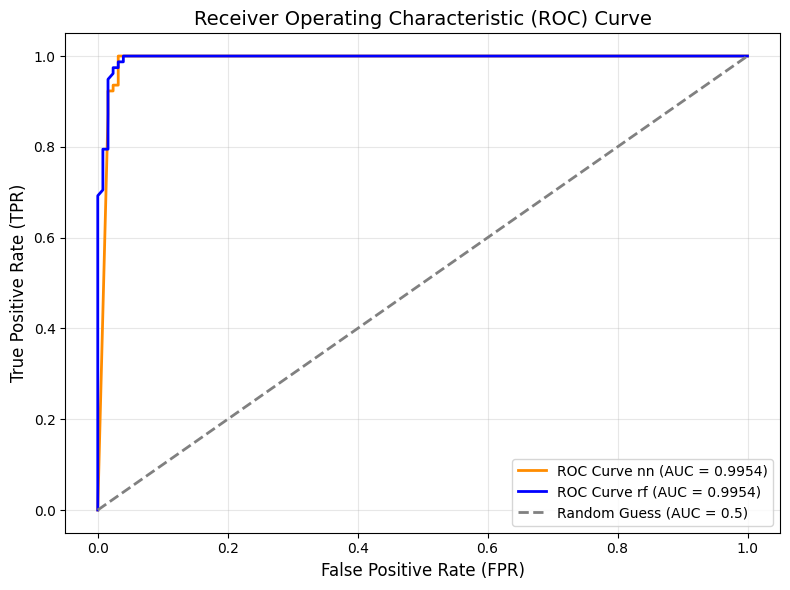

In [ ]:
# Calculate ROC curve for nn and rf algoritm
fpr_nn, tpr_nn, thresholds = roc_curve(y_test_bin_nn, y_pred_proba_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_bin_rf, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for nn and rf algoritm
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'ROC Curve nn (AUC = {roc_auc:.4f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC Curve rf (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

